In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from matplotlib.patches import Rectangle, Circle
from matplotlib.cm import ScalarMappable
from scipy.stats import chi2
from astropy.io import fits
from astropy.wcs import WCS
from reproject import reproject_interp
from reproject.mosaicking import find_optimal_celestial_wcs


In [ ]:

# Cargar datos
df_gradient = pd.read_csv('gradiente_scarano_ne_masa_edad_newnumber_ne10.csv', delimiter=',')
df_slits = pd.read_csv('output_scarano.csv')
df_signed = pd.read_csv('signed_distances.csv', delimiter=',')
df_gradient = pd.merge(df_gradient, df_signed, on='ID')

In [ ]:


# Definir grupos
group_left = df_gradient[df_gradient['signed_distance_kpc'] < 0]
group_right_galaxy = df_gradient[(df_gradient['signed_distance_kpc'] >= 0) & (df_gradient['ID'].isin([1, 2, 3]))]
group_clouds = df_gradient[df_gradient['ID'].isin(range(11, 20))]


In [ ]:

# Verificar número de puntos en cada grupo
print(f"Number of points in group_left: {len(group_left)}")
print(f"Number of points in group_right_galaxy: {len(group_right_galaxy)}")
print(f"Number of points in group_clouds: {len(group_clouds)}")

In [ ]:
# Parámetros de los slits
width_deg = 0.0075
height_deg = 0.0015
ra_center = 49.566875
dec_center = -66.498250
circle_radius_deg = 0.0002


In [ ]:

# Cargar imágenes FITS
hdul1 = fits.open('mrgS20190730S0157_add.fits')
data1 = hdul1['SCI'].data
wcs1 = WCS(hdul1['SCI'].header)

hdul2 = fits.open('mrgS20190730S0160_add.fits')
data2 = hdul2['SCI'].data
wcs2 = WCS(hdul2['SCI'].header)

In [ ]:

# Enmascarar valores de bordes
data1 = np.where(data1 == 593.67285, np.nan, data1)
data2 = np.where(data2 == 380.0607, np.nan, data2)

In [ ]:
# Parámetro para las colorbars
color_param = 'mass'

param_labels = {
    'mass': '$log(M_*)[M_{\odot}]$',
    '12_LOG_OH_N2': '12 + log(O/H)',
    'age': 'Edad [Gyr]'
}

# Límites para la colorbar
vmin = df_gradient[color_param].min()
vmax = df_gradient[color_param].max()
norm = Normalize(vmin=vmin, vmax=vmax)
cmap = plt.cm.cool


# Reproyectar y combinar imágenes
new_wcs, new_shape = find_optimal_celestial_wcs([(data1, wcs1), (data2, wcs2)])
reproj1, _ = reproject_interp((data1, wcs1), new_wcs, shape_out=new_shape)
reproj2, _ = reproject_interp((data2, wcs2), new_wcs, shape_out=new_shape)
combined = np.nanmean([reproj1, reproj2], axis=0)
combined = np.where(combined > 0, combined, np.nan)


Lado Izquierdo (signed_distance_kpc < 0):
Pendiente: -0.0184
Intercepto: 8.0882
Chi-cuadrado red.: 1.13

Galaxia (Derecho, IDs 1-3, signed_distance_kpc >= 0):
Pendiente: -0.1240
Intercepto: 8.3292
Chi-cuadrado red.: 0.62

Nubes (IDs 11-19):
Pendiente: 0.0031
Intercepto: 8.1649
Chi-cuadrado red.: 0.51
x_fit2 range: 1.0566975100962768 to 2.373826515813847
y_fit2 range: 8.034734832357852 to 8.198122478059663


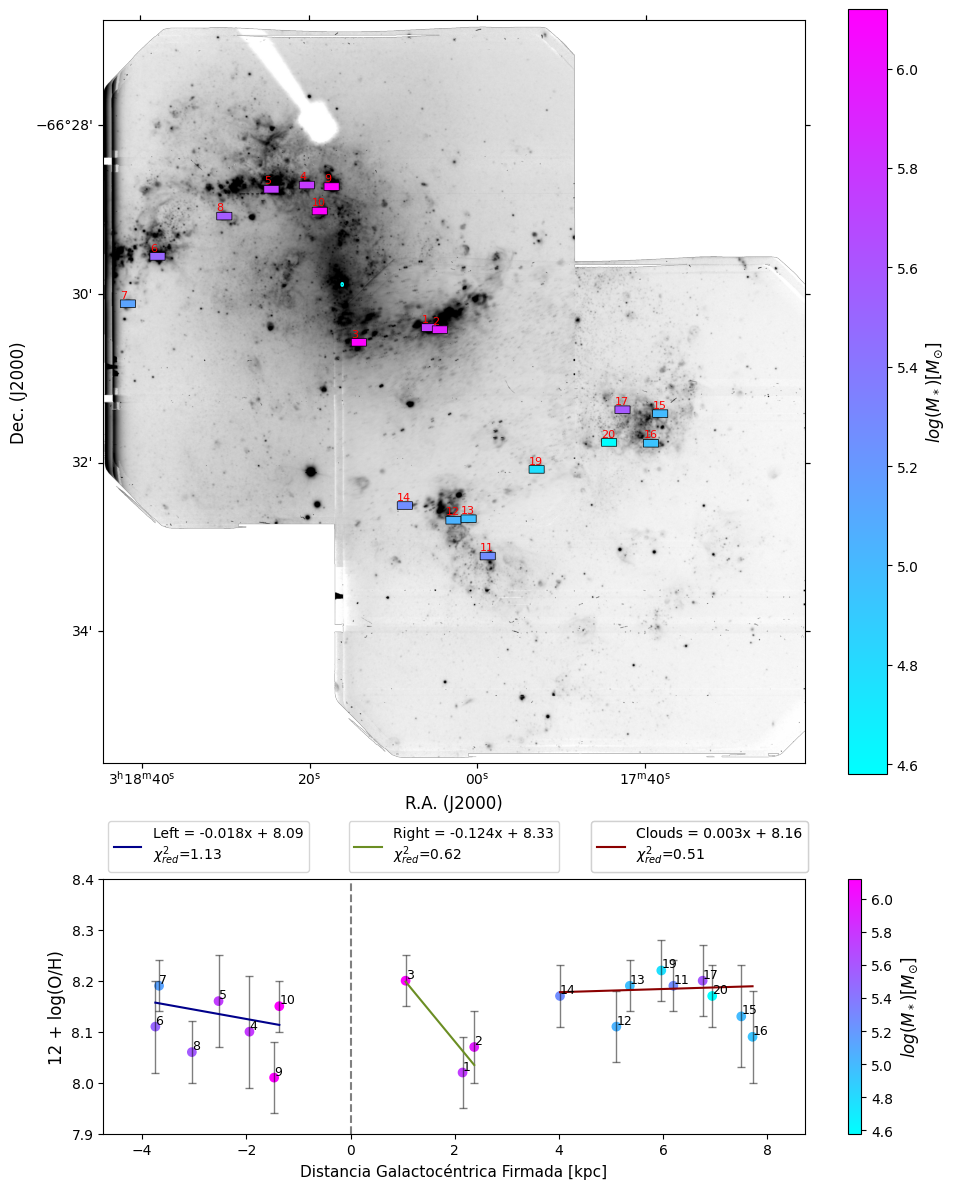

In [8]:
fig = plt.figure(figsize=(10, 12))
gs = fig.add_gridspec(2, 1, height_ratios=[3, 1])
ax1 = fig.add_subplot(gs[0], projection=new_wcs)
ax2 = fig.add_subplot(gs[1])

# Gráfico superior: imagen de la galaxia
ax1.imshow(combined, origin='lower', cmap='gray_r', norm=LogNorm(vmin=np.nanpercentile(combined, 1), vmax=np.nanpercentile(combined, 99)))
ax1.set_xlabel('R.A. (J2000)', fontsize=12)
ax1.set_ylabel('Dec. (J2000)', fontsize=12)

# Añadir slits
for _, row in df_slits.iterrows():
    ra, dec, slit_id = row['RA'], row['DEC'], row['ID']
    param_value = df_gradient[df_gradient['ID'] == slit_id][color_param].values
    if len(param_value) > 0:
        color = cmap(norm(param_value[0]))
    else:
        color = 'gray'
    rect = Rectangle(
        (ra - width_deg/2, dec - height_deg/2),
        width_deg, height_deg,
        edgecolor='black', facecolor=color, lw=0.5,
        transform=ax1.get_transform('world')
    )
    ax1.add_patch(rect)
    ax1.text(
        ra + width_deg/2, dec + height_deg/2, str(int(slit_id)),
        color='red', fontsize=8, transform=ax1.get_transform('world'),
        va='bottom', ha='left'
    )

# Añadir círculo azul
circle = Circle(
    (ra_center, dec_center), circle_radius_deg,
    edgecolor='cyan', facecolor='none', lw=2,
    transform=ax1.get_transform('world')
)
ax1.add_patch(circle)
ax1.set_ylim(440, 3740)

# Barra de color para la imagen
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar1 = fig.colorbar(sm, ax=ax1)
cbar1.set_label(param_labels[color_param], fontsize=12)

# Gráfico inferior: gradiente galactocéntrico
x = df_gradient['signed_distance_kpc'].values
y = df_gradient['12_LOG_OH_N2'].values
sigma_y = df_gradient['12_LOG_OH_N2_ERR'].values

# Ajuste lineal ponderado para Lado Izquierdo
if len(group_left) > 1:
    x1 = group_left['signed_distance_kpc'].values
    y1 = group_left['12_LOG_OH_N2'].values
    sigma_y1 = group_left['12_LOG_OH_N2_ERR'].values
    weights1 = 1 / sigma_y1**2
    m1, b1 = np.polyfit(x1, y1, deg=1, w=weights1)
    y_pred1 = m1 * x1 + b1
    chi_squared1 = np.sum((y1 - y_pred1)**2 / sigma_y1**2)
    dof1 = len(x1) - 2
    reduced_chi_squared1 = chi_squared1 / dof1 if dof1 > 0 else np.nan
else:
    m1, b1, reduced_chi_squared1 = np.nan, np.nan, np.nan

# Ajuste lineal ponderado para Galaxia (Derecho)
if len(group_right_galaxy) > 1:
    x2 = group_right_galaxy['signed_distance_kpc'].values
    y2 = group_right_galaxy['12_LOG_OH_N2'].values
    sigma_y2 = group_right_galaxy['12_LOG_OH_N2_ERR'].values
    weights2 = 1 / sigma_y2**2
    m2, b2 = np.polyfit(x2, y2, deg=1, w=weights2)
    y_pred2 = m2 * x2 + b2
    chi_squared2 = np.sum((y2 - y_pred2)**2 / sigma_y2**2)
    dof2 = len(x2) - 2
    reduced_chi_squared2 = chi_squared2 / dof2 if dof2 > 0 else np.nan
else:
    m2, b2, reduced_chi_squared2 = np.nan, np.nan, np.nan

# Ajuste lineal ponderado para Nubes
if len(group_clouds) > 1:
    x3 = group_clouds['signed_distance_kpc'].values
    y3 = group_clouds['12_LOG_OH_N2'].values
    sigma_y3 = group_clouds['12_LOG_OH_N2_ERR'].values
    weights3 = 1 / sigma_y3**2
    m3, b3 = np.polyfit(x3, y3, deg=1, w=weights3)
    y_pred3 = m3 * x3 + b3
    chi_squared3 = np.sum((y3 - y_pred3)**2 / sigma_y3**2)
    dof3 = len(x3) - 2
    reduced_chi_squared3 = chi_squared3 / dof3 if dof3 > 0 else np.nan
else:
    m3, b3, reduced_chi_squared3 = np.nan, np.nan, np.nan

# Imprimir estadísticas
print("Lado Izquierdo (signed_distance_kpc < 0):")
print(f"Pendiente: {m1:.4f}" if not np.isnan(m1) else "Pendiente: N/A")
print(f"Intercepto: {b1:.4f}" if not np.isnan(b1) else "Intercepto: N/A")
print(f"Chi-cuadrado red.: {reduced_chi_squared1:.2f}" if not np.isnan(reduced_chi_squared1) else "Chi-cuadrado red.: N/A")
print("\nGalaxia (Derecho, IDs 1-3, signed_distance_kpc >= 0):")
print(f"Pendiente: {m2:.4f}" if not np.isnan(m2) else "Pendiente: N/A")
print(f"Intercepto: {b2:.4f}" if not np.isnan(b2) else "Intercepto: N/A")
print(f"Chi-cuadrado red.: {reduced_chi_squared2:.2f}" if not np.isnan(reduced_chi_squared2) else "Chi-cuadrado red.: N/A")
print("\nNubes (IDs 11-19):")
print(f"Pendiente: {m3:.4f}" if not np.isnan(m3) else "Pendiente: N/A")
print(f"Intercepto: {b3:.4f}" if not np.isnan(b3) else "Intercepto: N/A")
print(f"Chi-cuadrado red.: {reduced_chi_squared3:.2f}" if not np.isnan(reduced_chi_squared3) else "Chi-cuadrado red.: N/A")

# Barras de error
ax2.errorbar(x, y, yerr=sigma_y, fmt='none', ecolor='black', capsize=3, alpha=0.5, elinewidth=1)

# Scatter con colorbar
sc = ax2.scatter(x, y, c=df_gradient[color_param], cmap=cmap, vmin=vmin, vmax=vmax)

# Etiquetas de ID
for xi, yi, idi in zip(x, y, df_gradient['ID']):
    ax2.text(xi, yi, str(int(idi)), fontsize=9, ha='left', va='bottom')

# Líneas de regresión
if len(group_left) > 1 and not np.isnan(m1):
    x_fit1 = np.linspace(np.min(x1), np.max(x1), 100)
    y_fit1 = m1 * x_fit1 + b1
    line1, = ax2.plot(x_fit1, y_fit1, color='darkblue', label=f"Left = {m1:.3f}x + {b1:.2f}\n$\chi^2_{{red}}$={reduced_chi_squared1:.2f}")

if len(group_right_galaxy) > 1 and not np.isnan(m2):
    x_fit2 = np.linspace(np.min(x2), np.max(x2), 100)
    y_fit2 = m2 * x_fit2 + b2
    line2, = ax2.plot(x_fit2, y_fit2, color='olivedrab', label=f"Right = {m2:.3f}x + {b2:.2f}\n$\chi^2_{{red}}$={reduced_chi_squared2:.2f}")
    print(f"x_fit2 range: {np.min(x_fit2)} to {np.max(x_fit2)}")
    print(f"y_fit2 range: {np.min(y_fit2)} to {np.max(y_fit2)}")

if len(group_clouds) > 1 and not np.isnan(m3):
    x_fit3 = np.linspace(np.min(x3), np.max(x3), 100)
    y_fit3 = m3 * x_fit3 + b3
    line3, = ax2.plot(x_fit3, y_fit3, color='darkred', label=f"Clouds = {m3:.3f}x + {b3:.2f}\n$\chi^2_{{red}}$={reduced_chi_squared3:.2f}")

# Línea vertical en x=0
ax2.axvline(0, linestyle='--', color='gray')

# Leyendas
if len(group_left) > 1 and not np.isnan(m1):
    legend1 = ax2.legend(handles=[line1], loc='lower center', bbox_to_anchor=(0.15, 1.0))
    ax2.add_artist(legend1)
if len(group_right_galaxy) > 1 and not np.isnan(m2):
    legend2 = ax2.legend(handles=[line2], loc='lower center', bbox_to_anchor=(0.5, 1.0))
    ax2.add_artist(legend2)
if len(group_clouds) > 1 and not np.isnan(m3):
    legend3 = ax2.legend(handles=[line3], loc='lower center', bbox_to_anchor=(0.85, 1.0))
    ax2.add_artist(legend3)

ax2.set_xlabel('Distancia Galactocéntrica Firmada [kpc]', fontsize=11)
ax2.set_ylabel('12 + log(O/H)', fontsize=12)
ax2.set_xlim(np.min(x) - 1, np.max(x) + 1)
ax2.set_ylim(7.9, 8.4)

# Barra de color para el gradiente
cbar2 = fig.colorbar(sc, ax=ax2)
cbar2.set_label(param_labels[color_param], fontsize=12)

# Ajustar diseño
plt.tight_layout()
plt.show()